# Cat-Dog Image Classifier

This notebook uses Tensorflow and Keras to create a Convolutional Neural network to classify images of cats and dogs.

The first code cell imports the required libraries. The second code cell downloads the data and sets key variables. 

The dataset used is hosted by FreeCodeCamp and contains 3000 labeled images and 50 unlabeled images used for testing. All images are color images containing all three color channels - RGB.

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
URL = 'https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip'  #downloading the data

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

70705152/70702765 [==============================] - 20s 0us/step



Next we create image generators for each of the three image data sets (train, validation, test) using `ImageDataGenerator` to read / decode the images and convert them into floating point tensors. We use the `rescale` argument  to rescale the tensors from values between 0 and 255 to values between 0 and 1.

For the `*_data_gen` variables, we use the `flow_from_directory` method. We pass in the batch size, directory, target size (`(IMG_HEIGHT, IMG_WIDTH)`), class mode, and anything else required.
The 'test_data' is unlabeled and therefore the directory path does not contain any labels, unlike the train and validation data. Therefore, we need to pass the directory as it is.


In [3]:
train_image_generator = ImageDataGenerator(rescale=1/255)
validation_image_generator = ImageDataGenerator(rescale=1/255)
test_image_generator = ImageDataGenerator(rescale=1/255)

train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
	 target_size=(IMG_HEIGHT, IMG_WIDTH),
	class_mode='binary',
  batch_size=128)

val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
	 target_size=(IMG_HEIGHT, IMG_WIDTH),
	class_mode='binary',
  batch_size=128)

test_data_gen = test_image_generator.flow_from_directory(
    PATH, classes = ['test'],
	 target_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=128,
  shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


The `plotImages` function will be used a few times to plot images. It takes an array of images and a probabilities list.
Running the cell below will plot five random training images.

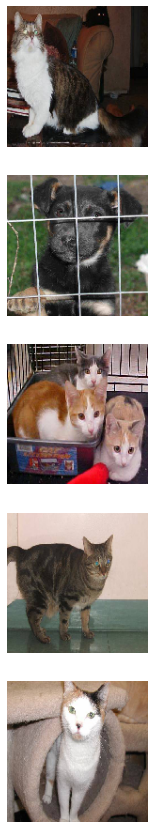

In [4]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


Recreate the `train_image_generator` using `ImageDataGenerator`. 

Since there are a small number of training examples there is a risk of overfitting. One way to fix this problem is by creating more training data from existing training examples by using random transformations.

We add 6 random transformations as arguments to `ImageDataGenerator`.


In [5]:
train_image_generator = ImageDataGenerator(
    rescale = 1./255,
	    rotation_range=50,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


 `train_data_gen` is created just like before but with the new `train_image_generator`. Then, a single image is plotted five different times using different variations.

Found 2000 images belonging to 2 classes.


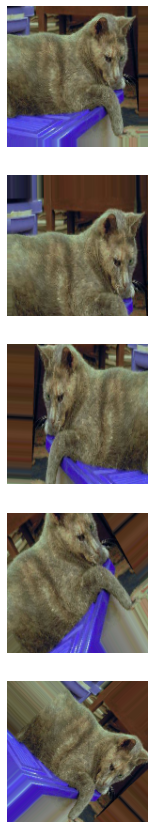

In [6]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In the cell below, we create a model for the neural network that outputs class probabilities. It uses the Keras Sequential model and involves a stack of Conv2D and MaxPooling2D layers and then a fully connected layer on top that is activated by a ReLU activation function.
This is then fed to a dense network with the final layer being a single neuron with a sigmoid activation function, to give probability.

We then compile the model passing the arguments to set the optimizer and loss. 

In [7]:
model = Sequential([
    #1st convolution
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),
    #2nd convolution
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    #3rd convolution
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    #4th convolution
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    #5th convolution
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    
    #flatten the output of the convolutions to feed to the dense network
    Flatten(),
    Dropout(0.5),
    
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       7

In [9]:
history = model.fit(x=train_data_gen, epochs=20, steps_per_epoch=15, validation_data = val_data_gen, verbose = 1, validation_steps=7)

Epoch 1/20
15/15 [==============================] - 15s 1s/step - loss: 0.5856 - accuracy: 0.6923 - val_loss: 0.6051 - val_accuracy: 0.6373
Epoch 2/20
15/15 [==============================] - 15s 999ms/step - loss: 0.6026 - accuracy: 0.6736 - val_loss: 0.5913 - val_accuracy: 0.6998
Epoch 3/20
15/15 [==============================] - 15s 1s/step - loss: 0.6208 - accuracy: 0.6656 - val_loss: 0.5924 - val_accuracy: 0.6663
Epoch 4/20
15/15 [==============================] - 15s 1s/step - loss: 0.6006 - accuracy: 0.6811 - val_loss: 0.5593 - val_accuracy: 0.7277
Epoch 5/20
15/15 [==============================] - 15s 1s/step - loss: 0.5801 - accuracy: 0.6955 - val_loss: 0.5971 - val_accuracy: 0.6641
Epoch 6/20
15/15 [==============================] - 15s 1s/step - loss: 0.5998 - accuracy: 0.6656 - val_loss: 0.5452 - val_accuracy: 0.7623
Epoch 7/20
15/15 [==============================] - 15s 994ms/step - loss: 0.5946 - accuracy: 0.6757 - val_loss: 0.5457 - val_accuracy: 0.7500
Epoch 8/20
15/

Visualizing the accuracy and loss of the model.

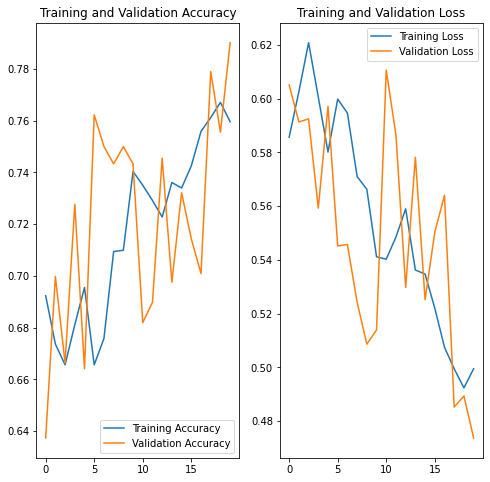

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Now it is time to use your model to predict whether a brand new image is a cat or a dog.

In this final cell, get the probability that each test image (from `test_data_gen`) is a dog or a cat. `probabilities` should be a list of integers. 

Call the `plotImages` function and pass in the test images and the probabilities corresponding to each test image.

After your run the cell, you should see all 50 test images with a label showing the percentage sure that the image is a cat or a dog. The accuracy will correspond to the accuracy shown in the graph above (after running the previous cell). More training images could lead to a higher accuracy.

In [13]:
probabilities = model.predict(test_data_gen)


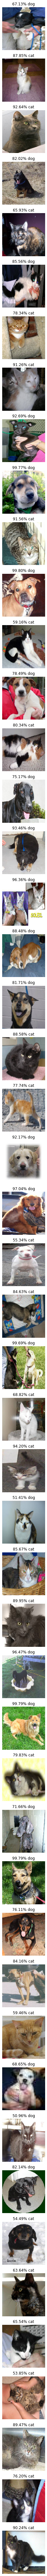

In [14]:
sample_test_images,_ = next(test_data_gen)
plotImages(sample_test_images,probabilities=probabilities)